CHL MO AQUA/MODIS

=== Clipping entire NetCDF file to shapefile ===
Opening NetCDF file: CHL_MO_subset_combined.nc4
Reading shapefile: Study_Areas/Caribbean_Study_area.shp
Dataset shape: {'time': 121, 'lat': 2040, 'lon': 3120, 'rgb': 3, 'eightbitcolor': 256}
Variables: ['chlor_a', 'palette']
Spatial dimensions: latitude='lat', longitude='lon'
Variables in dataset:
  - chlor_a: ('time', 'lat', 'lon') (121, 2040, 3120)
  - palette: ('time', 'rgb', 'eightbitcolor') (121, 3, 256)
  - chlor_a: has spatial dimensions, will be clipped
  - palette: no spatial dimensions, will be preserved as-is
Clipping spatial variables to shapefile boundary...


C:\Users\jspier\AppData\Local\Temp\ipykernel_18532\1703522328.py:38: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Dataset shape: {dict(xds.dims)}")


Saving clipped data to: study_data/Caribbean/CHL_MO_Caribbean.nc4

Clipping completed successfully!
Output dimensions: {'lat': 338, 'lon': 360, 'time': 121, 'rgb': 3, 'eightbitcolor': 256}
Variables clipped:
  - chlor_a: (121, 338, 360)
  - palette: (121, 3, 256)
Done! Your clipped NetCDF file is ready.

=== Creating verification plot ===
Creating verification plot for variable: chlor_a


C:\Users\jspier\AppData\Local\Temp\ipykernel_18532\1703522328.py:100: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Output dimensions: {dict(clipped_ds.dims)}")


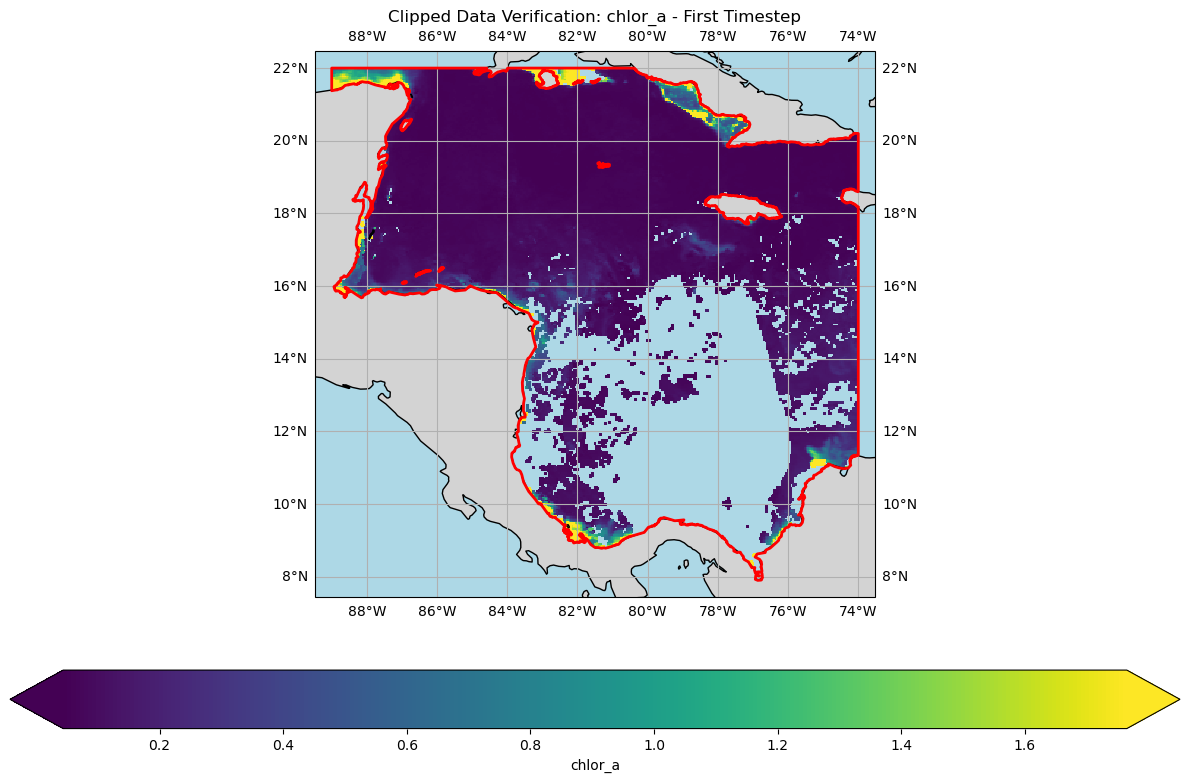

Verification plot saved: verification_plots/clipping_verification_chlor_a.png
Verification plot saved: verification_plots/clipping_verification_chlor_a.png
Check the 'verification_plots' folder for the visualization!


In [8]:
import os
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def clip_netcdf_to_shapefile(netcdf_file, shapefile_path, output_file):
    """
    Clip an entire NetCDF file (all variables, all timesteps) to a shapefile boundary.
    
    Parameters:
    -----------
    netcdf_file : str
        Path to the input NetCDF file
    shapefile_path : str
        Path to the shapefile for clipping
    output_file : str
        Path for the output clipped NetCDF file
    
    Returns:
    --------
    xarray.Dataset or None
        Clipped dataset if successful, None if failed
    """
    
    try:
        print(f"Opening NetCDF file: {netcdf_file}")
        
        # Read shapefile and ensure it's in WGS84
        print(f"Reading shapefile: {shapefile_path}")
        study_area = gpd.read_file(shapefile_path)
        study_area_wgs84 = study_area.to_crs("EPSG:4326")
        
        # Open the NetCDF dataset
        xds = xr.open_dataset(netcdf_file)
        
        print(f"Dataset shape: {dict(xds.dims)}")
        print(f"Variables: {list(xds.data_vars.keys())}")
        
        # Find spatial dimensions (latitude and longitude)
        lat_dim = None
        lon_dim = None
        
        for dim in xds.dims:
            if 'lat' in dim.lower():
                lat_dim = dim
            elif 'lon' in dim.lower():
                lon_dim = dim
        
        if lat_dim is None or lon_dim is None:
            raise ValueError(f"Could not identify lat/lon dimensions. Available dimensions: {list(xds.dims.keys())}")
        
        print(f"Spatial dimensions: latitude='{lat_dim}', longitude='{lon_dim}'")
        
        print(f"Variables in dataset:")
        for var_name, var_data in xds.data_vars.items():
            print(f"  - {var_name}: {var_data.dims} {var_data.shape}")
        
        # Identify which variables have spatial dimensions that can be clipped
        spatial_vars = {}
        non_spatial_vars = {}
        
        for var_name, var_data in xds.data_vars.items():
            if lat_dim in var_data.dims and lon_dim in var_data.dims:
                spatial_vars[var_name] = var_data
                print(f"  - {var_name}: has spatial dimensions, will be clipped")
            else:
                non_spatial_vars[var_name] = var_data
                print(f"  - {var_name}: no spatial dimensions, will be preserved as-is")
        
        if not spatial_vars:
            raise ValueError("No variables found with spatial dimensions to clip!")
        
        # Create a dataset with only spatial variables for clipping
        spatial_ds = xr.Dataset(spatial_vars, coords=xds.coords)
        
        # Set up rioxarray for clipping
        spatial_ds = spatial_ds.rio.set_spatial_dims(x_dim=lon_dim, y_dim=lat_dim)
        spatial_ds.rio.write_crs("EPSG:4326", inplace=True)
        
        # Clip the spatial variables to the shapefile boundary
        print("Clipping spatial variables to shapefile boundary...")
        clipped_spatial = spatial_ds.rio.clip(study_area_wgs84.geometry.values, study_area_wgs84.crs, drop=True)
        
        # Combine clipped spatial variables with non-spatial variables
        clipped_ds = clipped_spatial.copy()
        for var_name, var_data in non_spatial_vars.items():
            clipped_ds[var_name] = var_data
        
        # Create output directory if needed
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        
        # Save the clipped dataset
        print(f"Saving clipped data to: {output_file}")
        clipped_ds.to_netcdf(output_file)
        
        # Print summary
        print(f"\nClipping completed successfully!")
        print(f"Output dimensions: {dict(clipped_ds.dims)}")
        print(f"Variables clipped:")
        for var in clipped_ds.data_vars:
            print(f"  - {var}: {clipped_ds[var].shape}")
        
        return clipped_ds
        
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        return None
    except Exception as e:
        print(f"Error processing file: {e}")
        return None

def visualize_first_timestep(clipped_dataset, shapefile_path, output_dir='verification_plots'):
    """
    Create a quick visualization of the first timestep to verify clipping worked.
    
    Parameters:
    -----------
    clipped_dataset : xarray.Dataset
        The clipped dataset to visualize
    shapefile_path : str
        Path to the shapefile (for overlay)
    output_dir : str
        Directory to save the verification plot
    """
    
    try:
        os.makedirs(output_dir, exist_ok=True)
        
        # Read shapefile for overlay
        study_area = gpd.read_file(shapefile_path)
        study_area_wgs84 = study_area.to_crs("EPSG:4326")
        
        # Find the first data variable to plot
        data_vars = list(clipped_dataset.data_vars.keys())
        if not data_vars:
            print("No data variables found to plot.")
            return
        
        var_to_plot = data_vars[0]
        data = clipped_dataset[var_to_plot]
        
        print(f"Creating verification plot for variable: {var_to_plot}")
        
        # Find time dimension and select first timestep if it exists
        time_dim = None
        for dim in data.dims:
            if 'time' in dim.lower():
                time_dim = dim
                break
        
        if time_dim is not None:
            # Select first timestep
            plot_data = data.isel({time_dim: 0})
            time_info = f" - First Timestep"
        else:
            plot_data = data
            time_info = ""
        
        # Create the plot
        plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=ccrs.PlateCarree())
        
        # Add map features
        ax.coastlines()
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
        ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        
        # Plot the data
        if plot_data.size > 0 and not plot_data.isnull().all():
            im = plot_data.plot(
                ax=ax,
                transform=ccrs.PlateCarree(),
                cmap='viridis',
                cbar_kwargs={
                    'label': f'{var_to_plot}',
                    'orientation': 'horizontal',
                    'pad': 0.1
                },
                robust=True  # Use robust scaling to handle outliers
            )
        else:
            print("Warning: No valid data to plot after clipping.")
        
        # Overlay shapefile boundary
        study_area_wgs84.boundary.plot(
            ax=ax,
            color='red',
            linewidth=2,
            transform=ccrs.PlateCarree()
        )
        
        # Set extent based on clipped data
        if plot_data.size > 0:
            # Get bounds from the data
            lon_coords = plot_data.coords[list(plot_data.dims)[-1]]  # Usually longitude is last
            lat_coords = plot_data.coords[list(plot_data.dims)[-2]]  # Usually latitude is second to last
            
            lon_min, lon_max = float(lon_coords.min()), float(lon_coords.max())
            lat_min, lat_max = float(lat_coords.min()), float(lat_coords.max())
            
            # Add small padding
            pad = 0.5
            ax.set_extent([lon_min - pad, lon_max + pad, lat_min - pad, lat_max + pad])
        
        plt.title(f'Clipped Data Verification: {var_to_plot}{time_info}')
        plt.tight_layout()
        
        # Save the plot
        output_filename = f'{output_dir}/clipping_verification_{var_to_plot}.png'
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        
        # Display the plot
        plt.show()
        
        print(f"Verification plot saved: {output_filename}")
        print(f"Verification plot saved: {output_filename}")
        
    except Exception as e:
        print(f"Error creating verification plot: {e}")

if __name__ == "__main__":
    # Simple configuration - just specify your files
    netcdf_file = 'CHL_MO_subset_combined.nc4'
    shapefile_path = 'Study_Areas/Caribbean_Study_area.shp'
    output_file = 'study_data/Caribbean/CHL_MO_Caribbean.nc4'
    
    # Clip the entire NetCDF file
    print("=== Clipping entire NetCDF file to shapefile ===")
    
    result = clip_netcdf_to_shapefile(
        netcdf_file=netcdf_file,
        shapefile_path=shapefile_path,
        output_file=output_file
    )
    
    if result is not None:
        print("Done! Your clipped NetCDF file is ready.")
        
        # Create verification plot
        print("\n=== Creating verification plot ===")
        visualize_first_timestep(
            clipped_dataset=result,
            shapefile_path=shapefile_path
        )
        print("Check the 'verification_plots' folder for the visualization!")
        
    else:
        print("Clipping failed. Check the error messages above.")

SST OSTIA MO

=== Clipping entire NetCDF file to shapefile ===
Opening NetCDF file: OSTIA_MO_subset_combined.nc
Reading shapefile: Study_Areas/Caribbean_Study_area.shp
Dataset shape: {'time': 121, 'lat': 1704, 'lon': 2602}
Variables: ['analysed_sst', 'analysis_error', 'sea_ice_fraction', 'mask']
Spatial dimensions: latitude='lat', longitude='lon'
Variables in dataset:
  - analysed_sst: ('time', 'lat', 'lon') (121, 1704, 2602)
  - analysis_error: ('time', 'lat', 'lon') (121, 1704, 2602)
  - sea_ice_fraction: ('time', 'lat', 'lon') (121, 1704, 2602)
  - mask: ('time', 'lat', 'lon') (121, 1704, 2602)
  - analysed_sst: has spatial dimensions, will be clipped
  - analysis_error: has spatial dimensions, will be clipped
  - sea_ice_fraction: has spatial dimensions, will be clipped
  - mask: has spatial dimensions, will be clipped
Clipping spatial variables to shapefile boundary...


C:\Users\jspier\AppData\Local\Temp\ipykernel_18532\3215960901.py:38: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Dataset shape: {dict(xds.dims)}")


Saving clipped data to: study_data/Caribbean/OSTIA_MO_Caribbean.nc4

Clipping completed successfully!
Output dimensions: {'lat': 282, 'lon': 300, 'time': 121}
Variables clipped:
  - analysed_sst: (121, 282, 300)
  - analysis_error: (121, 282, 300)
  - sea_ice_fraction: (121, 282, 300)
  - mask: (121, 282, 300)
Done! Your clipped NetCDF file is ready.

=== Creating verification plot ===
Creating verification plot for variable: analysed_sst


C:\Users\jspier\AppData\Local\Temp\ipykernel_18532\3215960901.py:100: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Output dimensions: {dict(clipped_ds.dims)}")


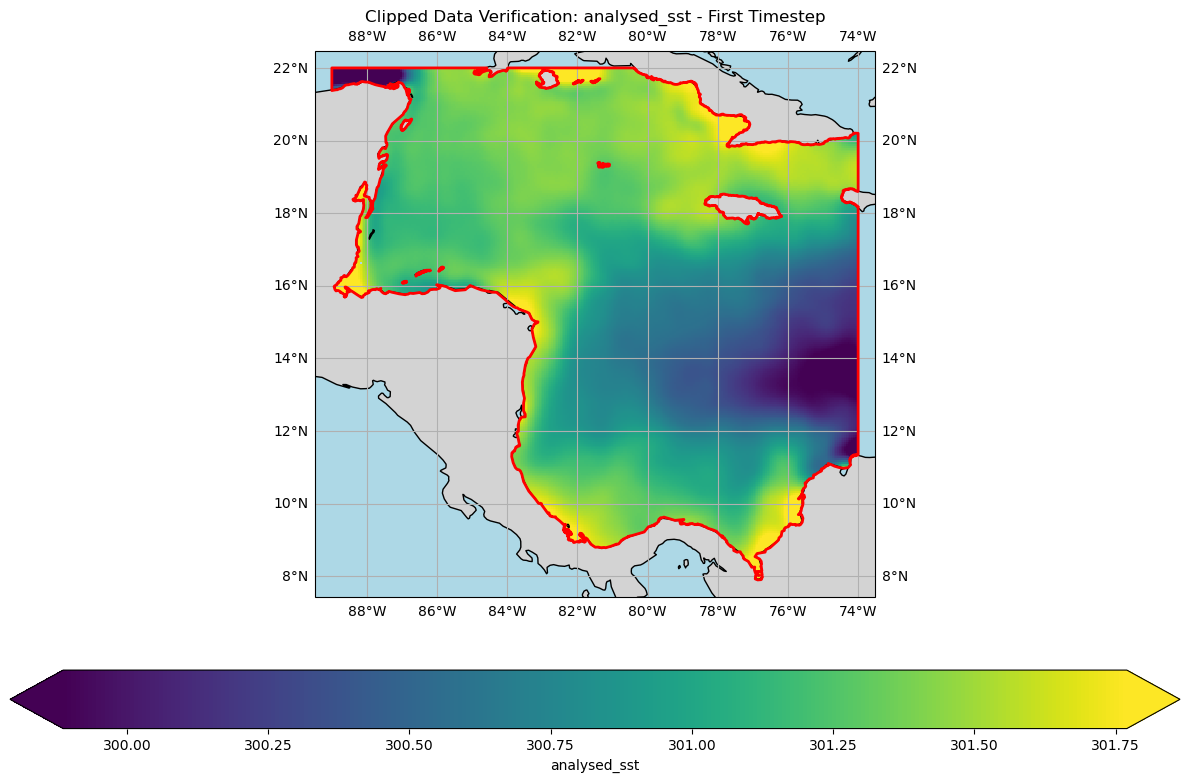

Verification plot saved: verification_plots/clipping_verification_analysed_sst.png
Verification plot saved: verification_plots/clipping_verification_analysed_sst.png
Check the 'verification_plots' folder for the visualization!


In [9]:
import os
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def clip_netcdf_to_shapefile(netcdf_file, shapefile_path, output_file):
    """
    Clip an entire NetCDF file (all variables, all timesteps) to a shapefile boundary.
    
    Parameters:
    -----------
    netcdf_file : str
        Path to the input NetCDF file
    shapefile_path : str
        Path to the shapefile for clipping
    output_file : str
        Path for the output clipped NetCDF file
    
    Returns:
    --------
    xarray.Dataset or None
        Clipped dataset if successful, None if failed
    """
    
    try:
        print(f"Opening NetCDF file: {netcdf_file}")
        
        # Read shapefile and ensure it's in WGS84
        print(f"Reading shapefile: {shapefile_path}")
        study_area = gpd.read_file(shapefile_path)
        study_area_wgs84 = study_area.to_crs("EPSG:4326")
        
        # Open the NetCDF dataset
        xds = xr.open_dataset(netcdf_file)
        
        print(f"Dataset shape: {dict(xds.dims)}")
        print(f"Variables: {list(xds.data_vars.keys())}")
        
        # Find spatial dimensions (latitude and longitude)
        lat_dim = None
        lon_dim = None
        
        for dim in xds.dims:
            if 'lat' in dim.lower():
                lat_dim = dim
            elif 'lon' in dim.lower():
                lon_dim = dim
        
        if lat_dim is None or lon_dim is None:
            raise ValueError(f"Could not identify lat/lon dimensions. Available dimensions: {list(xds.dims.keys())}")
        
        print(f"Spatial dimensions: latitude='{lat_dim}', longitude='{lon_dim}'")
        
        print(f"Variables in dataset:")
        for var_name, var_data in xds.data_vars.items():
            print(f"  - {var_name}: {var_data.dims} {var_data.shape}")
        
        # Identify which variables have spatial dimensions that can be clipped
        spatial_vars = {}
        non_spatial_vars = {}
        
        for var_name, var_data in xds.data_vars.items():
            if lat_dim in var_data.dims and lon_dim in var_data.dims:
                spatial_vars[var_name] = var_data
                print(f"  - {var_name}: has spatial dimensions, will be clipped")
            else:
                non_spatial_vars[var_name] = var_data
                print(f"  - {var_name}: no spatial dimensions, will be preserved as-is")
        
        if not spatial_vars:
            raise ValueError("No variables found with spatial dimensions to clip!")
        
        # Create a dataset with only spatial variables for clipping
        spatial_ds = xr.Dataset(spatial_vars, coords=xds.coords)
        
        # Set up rioxarray for clipping
        spatial_ds = spatial_ds.rio.set_spatial_dims(x_dim=lon_dim, y_dim=lat_dim)
        spatial_ds.rio.write_crs("EPSG:4326", inplace=True)
        
        # Clip the spatial variables to the shapefile boundary
        print("Clipping spatial variables to shapefile boundary...")
        clipped_spatial = spatial_ds.rio.clip(study_area_wgs84.geometry.values, study_area_wgs84.crs, drop=True)
        
        # Combine clipped spatial variables with non-spatial variables
        clipped_ds = clipped_spatial.copy()
        for var_name, var_data in non_spatial_vars.items():
            clipped_ds[var_name] = var_data
        
        # Create output directory if needed
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        
        # Save the clipped dataset
        print(f"Saving clipped data to: {output_file}")
        clipped_ds.to_netcdf(output_file)
        
        # Print summary
        print(f"\nClipping completed successfully!")
        print(f"Output dimensions: {dict(clipped_ds.dims)}")
        print(f"Variables clipped:")
        for var in clipped_ds.data_vars:
            print(f"  - {var}: {clipped_ds[var].shape}")
        
        return clipped_ds
        
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        return None
    except Exception as e:
        print(f"Error processing file: {e}")
        return None

def visualize_first_timestep(clipped_dataset, shapefile_path, output_dir='verification_plots'):
    """
    Create a quick visualization of the first timestep to verify clipping worked.
    
    Parameters:
    -----------
    clipped_dataset : xarray.Dataset
        The clipped dataset to visualize
    shapefile_path : str
        Path to the shapefile (for overlay)
    output_dir : str
        Directory to save the verification plot
    """
    
    try:
        os.makedirs(output_dir, exist_ok=True)
        
        # Read shapefile for overlay
        study_area = gpd.read_file(shapefile_path)
        study_area_wgs84 = study_area.to_crs("EPSG:4326")
        
        # Find the first data variable to plot
        data_vars = list(clipped_dataset.data_vars.keys())
        if not data_vars:
            print("No data variables found to plot.")
            return
        
        var_to_plot = data_vars[0]
        data = clipped_dataset[var_to_plot]
        
        print(f"Creating verification plot for variable: {var_to_plot}")
        
        # Find time dimension and select first timestep if it exists
        time_dim = None
        for dim in data.dims:
            if 'time' in dim.lower():
                time_dim = dim
                break
        
        if time_dim is not None:
            # Select first timestep
            plot_data = data.isel({time_dim: 0})
            time_info = f" - First Timestep"
        else:
            plot_data = data
            time_info = ""
        
        # Create the plot
        plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=ccrs.PlateCarree())
        
        # Add map features
        ax.coastlines()
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
        ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        
        # Plot the data
        if plot_data.size > 0 and not plot_data.isnull().all():
            im = plot_data.plot(
                ax=ax,
                transform=ccrs.PlateCarree(),
                cmap='viridis',
                cbar_kwargs={
                    'label': f'{var_to_plot}',
                    'orientation': 'horizontal',
                    'pad': 0.1
                },
                robust=True  # Use robust scaling to handle outliers
            )
        else:
            print("Warning: No valid data to plot after clipping.")
        
        # Overlay shapefile boundary
        study_area_wgs84.boundary.plot(
            ax=ax,
            color='red',
            linewidth=2,
            transform=ccrs.PlateCarree()
        )
        
        # Set extent based on clipped data
        if plot_data.size > 0:
            # Get bounds from the data
            lon_coords = plot_data.coords[list(plot_data.dims)[-1]]  # Usually longitude is last
            lat_coords = plot_data.coords[list(plot_data.dims)[-2]]  # Usually latitude is second to last
            
            lon_min, lon_max = float(lon_coords.min()), float(lon_coords.max())
            lat_min, lat_max = float(lat_coords.min()), float(lat_coords.max())
            
            # Add small padding
            pad = 0.5
            ax.set_extent([lon_min - pad, lon_max + pad, lat_min - pad, lat_max + pad])
        
        plt.title(f'Clipped Data Verification: {var_to_plot}{time_info}')
        plt.tight_layout()
        
        # Save the plot
        output_filename = f'{output_dir}/clipping_verification_{var_to_plot}.png'
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        
        # Display the plot
        plt.show()
        
        print(f"Verification plot saved: {output_filename}")
        print(f"Verification plot saved: {output_filename}")
        
    except Exception as e:
        print(f"Error creating verification plot: {e}")

if __name__ == "__main__":
    # Simple configuration - just specify your files
    netcdf_file = 'OSTIA_MO_subset_combined.nc'
    shapefile_path = 'Study_Areas/Caribbean_Study_area.shp'
    output_file = 'study_data/Caribbean/OSTIA_MO_Caribbean.nc4'
    
    # Clip the entire NetCDF file
    print("=== Clipping entire NetCDF file to shapefile ===")
    
    result = clip_netcdf_to_shapefile(
        netcdf_file=netcdf_file,
        shapefile_path=shapefile_path,
        output_file=output_file
    )
    
    if result is not None:
        print("Done! Your clipped NetCDF file is ready.")
        
        # Create verification plot
        print("\n=== Creating verification plot ===")
        visualize_first_timestep(
            clipped_dataset=result,
            shapefile_path=shapefile_path
        )
        print("Check the 'verification_plots' folder for the visualization!")
        
    else:
        print("Clipping failed. Check the error messages above.")

SSS SMAP MO

=== Clipping entire NetCDF file to shapefile ===
Opening NetCDF file: SMAP_MO_subset_combined_OISSSfilled.nc4
Reading shapefile: Study_Areas/Caribbean_Study_area.shp
Dataset shape: {'time': 121, 'latitude': 340, 'longitude': 520}
Variables: ['smap_sss_uncertainty', 'smap_spd', 'ice_fraction', 'anc_sst', 'weight', 'land_fraction', 'smap_high_spd', 'smap_sss', 'anc_sss', 'spatial_ref']
Spatial dimensions: latitude='latitude', longitude='longitude'
Variables in dataset:
  - smap_sss_uncertainty: ('time', 'latitude', 'longitude') (121, 340, 520)
  - smap_spd: ('time', 'latitude', 'longitude') (121, 340, 520)
  - ice_fraction: ('time', 'latitude', 'longitude') (121, 340, 520)
  - anc_sst: ('time', 'latitude', 'longitude') (121, 340, 520)
  - weight: ('time', 'latitude', 'longitude') (121, 340, 520)
  - land_fraction: ('time', 'latitude', 'longitude') (121, 340, 520)
  - smap_high_spd: ('time', 'latitude', 'longitude') (121, 340, 520)
  - smap_sss: ('time', 'latitude', 'longitude') (121, 340

C:\Users\jspier\AppData\Local\Temp\ipykernel_18532\1220433746.py:38: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Dataset shape: {dict(xds.dims)}")


Saving clipped data to: study_data/Caribbean/SMAP_MO_Caribbean.nc4

Clipping completed successfully!
Output dimensions: {'longitude': 60, 'latitude': 55, 'time': 121}
Variables clipped:
  - smap_sss_uncertainty: (121, 55, 60)
  - smap_spd: (121, 55, 60)
  - ice_fraction: (121, 55, 60)
  - anc_sst: (121, 55, 60)
  - weight: (121, 55, 60)
  - land_fraction: (121, 55, 60)
  - smap_high_spd: (121, 55, 60)
  - smap_sss: (121, 55, 60)
  - anc_sss: (121, 55, 60)
Done! Your clipped NetCDF file is ready.

=== Creating verification plot ===
Creating verification plot for variable: smap_sss_uncertainty


C:\Users\jspier\AppData\Local\Temp\ipykernel_18532\1220433746.py:100: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Output dimensions: {dict(clipped_ds.dims)}")


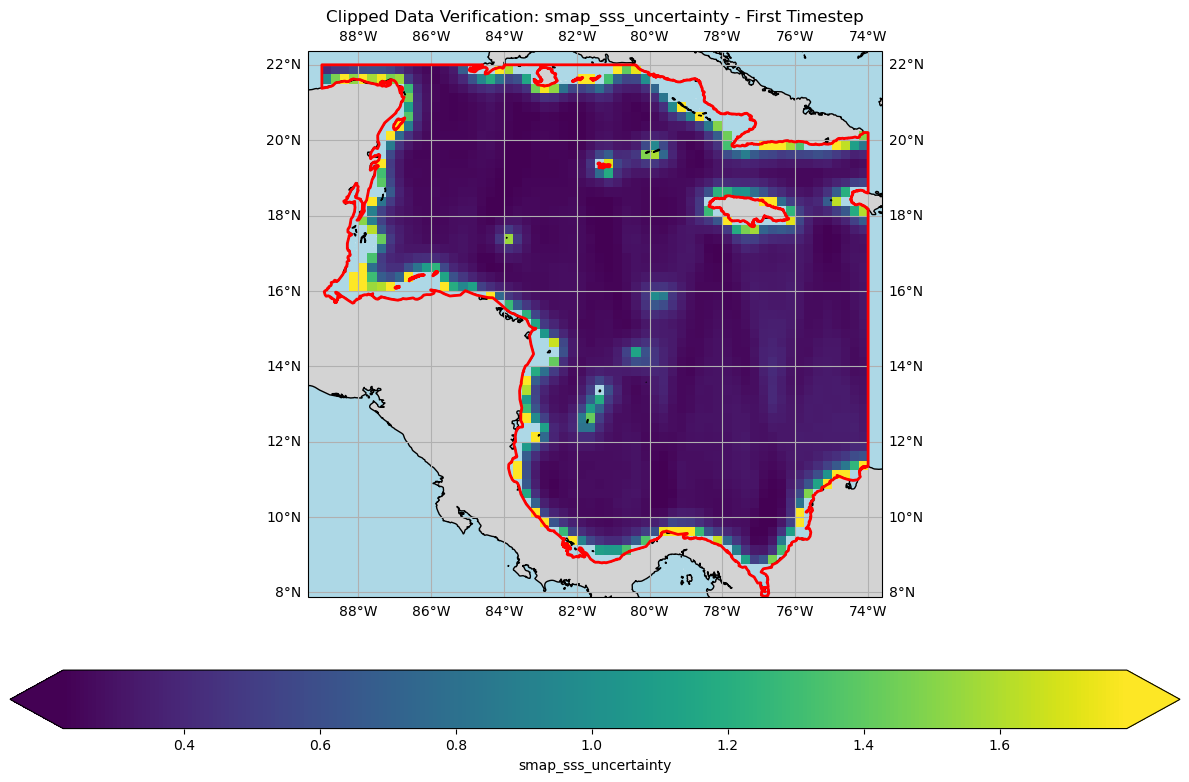

Verification plot saved: verification_plots/clipping_verification_smap_sss_uncertainty.png
Verification plot saved: verification_plots/clipping_verification_smap_sss_uncertainty.png
Check the 'verification_plots' folder for the visualization!


In [7]:
import os
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def clip_netcdf_to_shapefile(netcdf_file, shapefile_path, output_file):
    """
    Clip an entire NetCDF file (all variables, all timesteps) to a shapefile boundary.
    
    Parameters:
    -----------
    netcdf_file : str
        Path to the input NetCDF file
    shapefile_path : str
        Path to the shapefile for clipping
    output_file : str
        Path for the output clipped NetCDF file
    
    Returns:
    --------
    xarray.Dataset or None
        Clipped dataset if successful, None if failed
    """
    
    try:
        print(f"Opening NetCDF file: {netcdf_file}")
        
        # Read shapefile and ensure it's in WGS84
        print(f"Reading shapefile: {shapefile_path}")
        study_area = gpd.read_file(shapefile_path)
        study_area_wgs84 = study_area.to_crs("EPSG:4326")
        
        # Open the NetCDF dataset
        xds = xr.open_dataset(netcdf_file)
        
        print(f"Dataset shape: {dict(xds.dims)}")
        print(f"Variables: {list(xds.data_vars.keys())}")
        
        # Find spatial dimensions (latitude and longitude)
        lat_dim = None
        lon_dim = None
        
        for dim in xds.dims:
            if 'lat' in dim.lower():
                lat_dim = dim
            elif 'lon' in dim.lower():
                lon_dim = dim
        
        if lat_dim is None or lon_dim is None:
            raise ValueError(f"Could not identify lat/lon dimensions. Available dimensions: {list(xds.dims.keys())}")
        
        print(f"Spatial dimensions: latitude='{lat_dim}', longitude='{lon_dim}'")
        
        print(f"Variables in dataset:")
        for var_name, var_data in xds.data_vars.items():
            print(f"  - {var_name}: {var_data.dims} {var_data.shape}")
        
        # Identify which variables have spatial dimensions that can be clipped
        spatial_vars = {}
        non_spatial_vars = {}
        
        for var_name, var_data in xds.data_vars.items():
            if lat_dim in var_data.dims and lon_dim in var_data.dims:
                spatial_vars[var_name] = var_data
                print(f"  - {var_name}: has spatial dimensions, will be clipped")
            else:
                non_spatial_vars[var_name] = var_data
                print(f"  - {var_name}: no spatial dimensions, will be preserved as-is")
        
        if not spatial_vars:
            raise ValueError("No variables found with spatial dimensions to clip!")
        
        # Create a dataset with only spatial variables for clipping
        spatial_ds = xr.Dataset(spatial_vars, coords=xds.coords)
        
        # Set up rioxarray for clipping
        spatial_ds = spatial_ds.rio.set_spatial_dims(x_dim=lon_dim, y_dim=lat_dim)
        spatial_ds.rio.write_crs("EPSG:4326", inplace=True)
        
        # Clip the spatial variables to the shapefile boundary
        print("Clipping spatial variables to shapefile boundary...")
        clipped_spatial = spatial_ds.rio.clip(study_area_wgs84.geometry.values, study_area_wgs84.crs, drop=True)
        
        # Combine clipped spatial variables with non-spatial variables
        clipped_ds = clipped_spatial.copy()
        for var_name, var_data in non_spatial_vars.items():
            clipped_ds[var_name] = var_data
        
        # Create output directory if needed
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        
        # Save the clipped dataset
        print(f"Saving clipped data to: {output_file}")
        clipped_ds.to_netcdf(output_file)
        
        # Print summary
        print(f"\nClipping completed successfully!")
        print(f"Output dimensions: {dict(clipped_ds.dims)}")
        print(f"Variables clipped:")
        for var in clipped_ds.data_vars:
            print(f"  - {var}: {clipped_ds[var].shape}")
        
        return clipped_ds
        
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        return None
    except Exception as e:
        print(f"Error processing file: {e}")
        return None

def visualize_first_timestep(clipped_dataset, shapefile_path, output_dir='verification_plots'):
    """
    Create a quick visualization of the first timestep to verify clipping worked.
    
    Parameters:
    -----------
    clipped_dataset : xarray.Dataset
        The clipped dataset to visualize
    shapefile_path : str
        Path to the shapefile (for overlay)
    output_dir : str
        Directory to save the verification plot
    """
    
    try:
        os.makedirs(output_dir, exist_ok=True)
        
        # Read shapefile for overlay
        study_area = gpd.read_file(shapefile_path)
        study_area_wgs84 = study_area.to_crs("EPSG:4326")
        
        # Find the first data variable to plot
        data_vars = list(clipped_dataset.data_vars.keys())
        if not data_vars:
            print("No data variables found to plot.")
            return
        
        var_to_plot = data_vars[7]
        data = clipped_dataset[var_to_plot]
        
        print(f"Creating verification plot for variable: {var_to_plot}")
        
        # Find time dimension and select first timestep if it exists
        time_dim = None
        for dim in data.dims:
            if 'time' in dim.lower():
                time_dim = dim
                break
        
        if time_dim is not None:
            # Select first timestep
            plot_data = data.isel({time_dim: 0})
            time_info = f" - First Timestep"
        else:
            plot_data = data
            time_info = ""
        
        # Create the plot
        plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=ccrs.PlateCarree())
        
        # Add map features
        ax.coastlines()
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
        ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        
        # Plot the data
        if plot_data.size > 0 and not plot_data.isnull().all():
            im = plot_data.plot(
                ax=ax,
                transform=ccrs.PlateCarree(),
                cmap='viridis',
                cbar_kwargs={
                    'label': f'{var_to_plot}',
                    'orientation': 'horizontal',
                    'pad': 0.1
                },
                robust=True  # Use robust scaling to handle outliers
            )
        else:
            print("Warning: No valid data to plot after clipping.")
        
        # Overlay shapefile boundary
        study_area_wgs84.boundary.plot(
            ax=ax,
            color='red',
            linewidth=2,
            transform=ccrs.PlateCarree()
        )
        
        # Set extent based on clipped data
        if plot_data.size > 0:
            # Get bounds from the data
            lon_coords = plot_data.coords[list(plot_data.dims)[-1]]  # Usually longitude is last
            lat_coords = plot_data.coords[list(plot_data.dims)[-2]]  # Usually latitude is second to last
            
            lon_min, lon_max = float(lon_coords.min()), float(lon_coords.max())
            lat_min, lat_max = float(lat_coords.min()), float(lat_coords.max())
            
            # Add small padding
            pad = 0.5
            ax.set_extent([lon_min - pad, lon_max + pad, lat_min - pad, lat_max + pad])
        
        plt.title(f'Clipped Data Verification: {var_to_plot}{time_info}')
        plt.tight_layout()
        
        # Save the plot
        output_filename = f'{output_dir}/clipping_verification_{var_to_plot}.png'
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        
        # Display the plot
        plt.show()
        
        print(f"Verification plot saved: {output_filename}")
        print(f"Verification plot saved: {output_filename}")
        
    except Exception as e:
        print(f"Error creating verification plot: {e}")

if __name__ == "__main__":
    # Simple configuration - just specify your files
    netcdf_file = 'SMAP_MO_subset_combined_OISSSfilled.nc4'
    shapefile_path = 'Study_Areas/Caribbean_Study_area.shp'
    output_file = 'study_data/Caribbean/SMAP_MO_Caribbean.nc4'
    
    # Clip the entire NetCDF file
    print("=== Clipping entire NetCDF file to shapefile ===")
    
    result = clip_netcdf_to_shapefile(
        netcdf_file=netcdf_file,
        shapefile_path=shapefile_path,
        output_file=output_file
    )
    
    if result is not None:
        print("Done! Your clipped NetCDF file is ready.")
        
        # Create verification plot
        print("\n=== Creating verification plot ===")
        visualize_first_timestep(
            clipped_dataset=result,
            shapefile_path=shapefile_path
        )
        print("Check the 'verification_plots' folder for the visualization!")
        
    else:
        print("Clipping failed. Check the error messages above.")